## Probabilistic Programming with Differential Equation Models

In the first blog post we saw a simple example of how we can do Bayesian inference, when we have a probabilistic model to describe an atmospheric event or quantity. We used Bayesian inference to estimate the wind speed, which was a "latent variable", a quantity that that controls the observed variables but that can't be directly observed. 

We are interested in more complex models where we might be able to infer the latent variables describing the observed quantities. In this post I will attempt to demonstrate this for a more complex model that is built on differential equations. 


## 1D Linear Advection
A simple place to start is with the 1D Linear advection equation for a travelling wave. Let's assume we know the height of the wave at initialisation at time t=0. Then, we will observe it after time t. During this time, it follows the 1D linear advection equation which we know and have a model for, albeit an imperfect model.

We can use Bayesian inference to "infer" the speed of the wave, a latent variable in our model. Then we can use this to predict the shape of the full wave and where it will be at some future time, t. 


In [1]:
# libraries
import numpy as np                   
import matplotlib.pyplot as plt  

import time
import torch
import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist

# seed
np.random.seed(123)

First let's set up the model. I'm assuming that advection is deterministic and using a forward in time, backward in space discretisation. Note that this discretisation doesn't give us the exact solution but this makes it more relevant because in reality many of our models of real world systems are imperfect. Can we still use probabilistic programming to infer the latent variables of our imperfect model? 

## Initialise model
We will start with a grid of width L=10, with nx=200 grid points. The initial wave height is an cosine bell shape between 0 and 4.

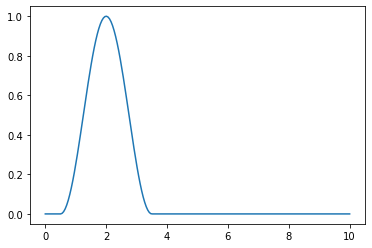

In [2]:
# Spatial parameters
L, nx = 10, 200
dx = L/(nx-1)

# Cosine bell shape 
def initial_cond(x, start, end):
    """ Initialise with a cosine bell between start and end. Arguments:
    x = grid of points on x-axis (tensor)
    start, end = positions of where cosine bell begins and ends """
    bell = lambda x: 0.5*(1 - torch.cos(2.*np.pi*(x-start)/(end - start)))
    return (torch.where((x<end) & (x>=start), bell(x), torch.tensor(0.)))

# Initialise and plot
x = torch.linspace(0., L, nx)
h0 = initial_cond(x, start=0.5, end=3.5)

plt.plot(x.numpy(),h0.numpy());

We have a differential equation for advection below. The following plot highlights how the wave propagates over `nt` timesteps of width `dt`. 

In [3]:
def advect(speed, h, nx, nt, dt, dx):
    """ Returns wave height after nt iterations following the 1D advection-diffusion equation.
    speed = speed of wave (tensor of dim 1)
    h = initial wave height (tensor of dim nx)
    nx = number of points on x-axis (int)
    nx, nt = number of grid points (int), number of timesteps to iterate for (int)
    dt, dx = timestep (float), space between grid points (float) 
    """
    # propagate in time for nt steps, hn is the next step
    hn = torch.zeros(nx)
    for n in range(nt): 
        hn[0] = 0.
        hn[1:] = h[1:] - speed * dt / dx * (h[1:] - h[0:-1])
        h = hn
    return h

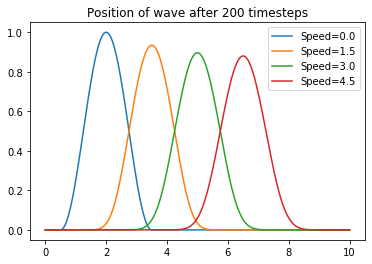

In [4]:
# Example plot for 3 different speeds, 1.5, 3, and 4.5
dt, nt = 0.005, 200
for speed in [0., 1.5, 3., 4.5]:
    plt.plot(x.numpy(), advect(speed, h0, nx, nt, dt, dx).numpy(), 
             label="Speed={}".format(str(speed)));
plt.title("Position of wave after {} timesteps".format(nt));
plt.legend();

Notice how the amplitude of the wave decays slightly due to the numerical errors in model. We will see if we can infer the speed of the wave, even though the model isn't perfect. 

#### A pyro model
We put this into the complete Pyro model below. There are 4 steps:
1.  Set up the initial conditions for the wave height
* Sample the latent variable, the wave speed, from our prior distribution 
* Run a deterministic finite difference scheme for the 1D advection equation to step forward in time 
* Sample the observed wave height, including the observation error. The observation error at each point is independent.

This model is more complicated than the simple example in the previous blog post, because we have many iterations of a time-stepping scheme embedded within it. This reflects the type of models we are typically doing inference on. 

In [5]:
def model(guess, observed_inds, nx, L, nt, dt, obs_err):
    """ Returns the height of the observed wave according to the 1D Linear advection
    model. Arguments:
    guess = prior guess for bounds on the speed of the wave, tuple (min, max)
    observed_inds = indices on the grid where the wave is observed, list
    nx, L  = number of grid points, length of grid
    nt, dt = number of iterations, timestep
    obs_err = observation error
    """
    # 1) Initialise grid and initial conditions 
    x = torch.linspace(0., L, nx)
    h0 = initial_cond(x, 0.5, 3.5)
    
    # 2) Sample speed, the latent variable
    min_speed, max_speed = guess
    speed = pyro.sample("speed", dist.Uniform(min_speed, max_speed))

    # 3) Put these initial conditions and the speed into our prediction model
    dx = L / (nx-1)
    pred_h = advect(speed, h0, nx, nt, dt, dx)
    
    # 4) We actually observe h with some observation error
    obs_h = torch.zeros(nx)
    for i in pyro.plate("x_axis", nx):
        # each point on the x-axis is assumed to be observed conditionally independent given the speed 
        if i in observed_inds:
            obs_h[i] = pyro.sample("h_{}".format(str(i)),
                               dist.Normal(pred_h[i], obs_err))     
        else:
            obs_h[i] = pred_h[i]

    return(speed, obs_h)

You might also notice we have an additional loop because we will observe the wave height at multiple points with independent measurement error on each observation. The pyro.plate("x_axis", nx) statement tells Pyro that these observations are conditionally independent (i.e. independent from each other but they all depend on the speed, which is outside of this loop). 

I've also assumed that we don't know much about the wave speed, so I've provided a vague prior - the speed is sampled uniformly between a minimum and maximum value.

This prior distribution is plotted in the histogram on the left, with the resulting wave heights plotted on the right for a few samples from the model.

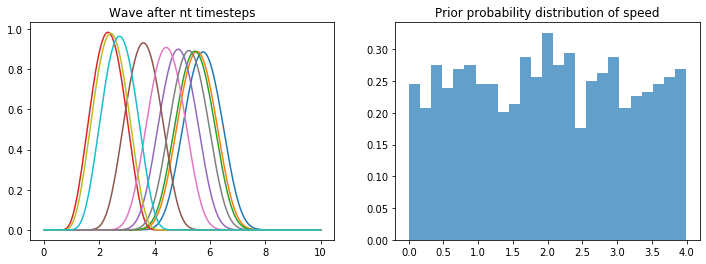

In [6]:
speed_uncond = []
fig = plt.figure(figsize=(12,4));
ax0 = plt.subplot2grid((1, 2), (0, 0));

obs_err = 0.01
guess = (0.,4.)
for i in range(1000):
    speed, h = model(guess, [], nx, L, nt, dt, 0.)
    if i < 10:
        ax0.plot(x.numpy(), h.detach().numpy())
    speed_uncond.append(speed)

plt.title("Wave after nt timesteps")
# Plot probability distribution of speed
ax1 = plt.subplot2grid((1, 2), (0, 1));
ax1.hist(speed_uncond, 25, density=True, alpha=0.7);
plt.title("Prior probability distribution of speed");

## Conditioning on Data
The next step is to condition on observations. In this case, we will assume we observe the wave at only some of the points on the grid. We can generate data that corresponds to the exact solution for a wave, using $h(x,t)=h_0(x-ct)$ where $h_0$ is the initial condition of the wave. For example, below I've generated some data using the analytical equation for a wave travelling at 1.65 m/s in blue. The discretised model produces the wave shown in orange.


In this case, we will assume we observe the wave at only some of the points on the grid. Also, the observations are noisy - there is some measurement error.  In the following section of code, we put the data in the appropriate format for pyro.

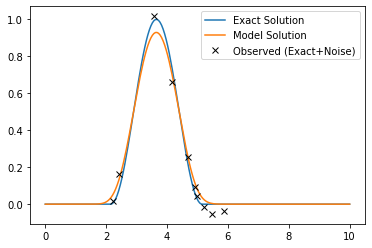

In [7]:
true_speed = 1.65
obs_err = 0.05

exact_h = initial_cond(x-true_speed*nt*dt, 0.5 , 3.5)
plt.plot(x.numpy(), exact_h.numpy(), label='Exact Solution');
plt.plot(x.numpy(), advect(true_speed, h0, nx, nt, dt, dx).numpy(), label='Model Solution');

N_obs = 10
observed_inds = np.random.choice(range(int(2*nx/10),int(6*nx/10)), size=N_obs, replace=False)
#plt.plot(x[observed_inds].numpy(), exact_h[observed_inds].numpy(), 'kx')
observed_h = exact_h[observed_inds] + dist.Normal(0., obs_err).sample(sample_shape=torch.Size([N_obs]))
plt.plot(x[observed_inds].numpy(), observed_h.numpy(), 'kx', label='Observed (Exact+Noise)')

plt.legend()

# Put into data dictionary with named labels
keys = ["h_{}".format(str(i)) for i in observed_inds]
data = dict(zip(keys, observed_h))


In [8]:
conditioned_model = pyro.condition(model, data=data)

This statement only fixes the waveheight at the observed points. If we run this function, we see that speed is still sampled from the prior distribution and the waveheight is calculated based on this. However, pyro then effectively overwrites the wave height at observed points with the data. We can see this in the plot below.

tensor(1.5697)


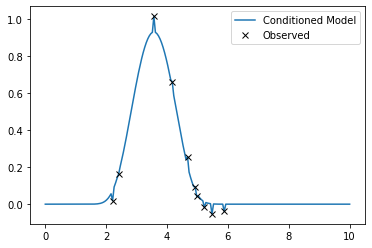

In [9]:
speed, h = conditioned_model(guess, observed_inds, nx, L, nt, dt, 0.)
fig = plt.figure(figsize=(6,4));
plt.plot(x.numpy(), h.detach().numpy(), label='Conditioned Model');
plt.plot(x[observed_inds].numpy(), observed_h.numpy(), 'kx', label='Observed');
plt.legend();
print(speed)

## Inference
We want to find a function that samples the entire wave based on the data. Following the same method as before we will infer the latent variable, speed, using Stochastic Variational Inference (SVI). The following piece of code defines the "guide" which is an approximation to the posterior distribution for the speed.

In [10]:
from torch.distributions import constraints
pyro.clear_param_store()
def parameterised_guide(guess, observed_inds, nx, L, nt, dt, obs_err):
    """Approximates the posterior distribution for the latent variable, speed"""
    # 1) Initialise grid and initial conditions 
    x = torch.linspace(0., L, nx)
    h0 = initial_cond(x, 0.5, 3.5)
    
    # 2) Sample speed, the latent variable
    # Initialise the variational parameters we will learn
    a = pyro.param("a", torch.tensor((guess[1]+guess[0])/2.))  # centre Normal dist between min and max
    b = pyro.param("b", torch.tensor((guess[1]-guess[0])/6.), 
                   constraint=constraints.positive)            # scale of Normal dist 
    # Sample speed using variational parameters
    speed = pyro.sample("speed", dist.Normal(a, b))
    
    return(speed)



The following cell defines functions for plotting the output.

In [11]:
# Plotting function for guide
def plot_guide_wave(x, guess, observed_h, observed_inds, nx, L, nt, dt, obs_err):
    plt.plot(x.numpy()[observed_inds],
             observed_h.numpy(),'rx',label="Observed");
    not_observed_inds = [i for i in range(nx) 
                         if i not in observed_inds]
    speed = parameterised_guide(guess, observed_inds, nx, L, nt, dt, obs_err).item()
    h = advect(speed, h0, nx, nt, dt, dx)
    plt.plot(x.numpy()[not_observed_inds],
             h.detach().numpy()[not_observed_inds],'bx',alpha=0.2,label="Sample");
    for i in range(20):
        speed = parameterised_guide(guess, observed_inds, nx, L, nt, dt, obs_err).item()
        h = advect(speed, h0, nx, nt, dt, dx)
        plt.plot(x.numpy()[not_observed_inds],
             h.detach().numpy()[not_observed_inds],'bx',alpha=0.2);

        
def plot_at_iteration(t, x, guess, observed_h, observed_inds, nx, L, nt, dt, obs_err):
    print('Iteration {}'.format(str(t)))
    print("a=",pyro.param("a").item(),",  b=",pyro.param("b").item())
    plt.clf();
    fig = plt.figure(figsize=(8, 4));
    not_observed_inds = [i for i in range(nx) if i not in observed_inds]
    plot_guide_wave(x, guess, observed_h, observed_inds, nx, L, nt, dt, obs_err)
    speed_mean = pyro.param("a").item()
    mean_h = advect(speed_mean, h0, nx, nt, dt, dx)
    plt.plot(x.numpy()[not_observed_inds],
     mean_h.numpy()[not_observed_inds], 'kx', lw=2,label="Mean");
    plt.legend();
    plt.title('Iteration {}'.format(str(t)));
    plt.show();

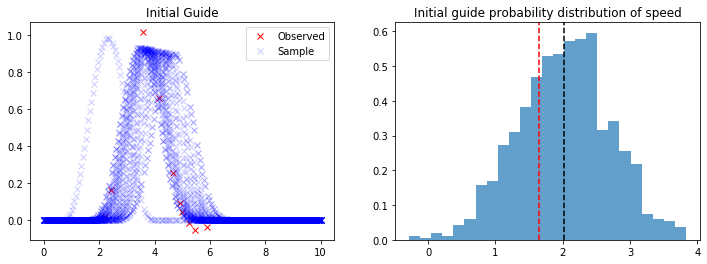

In [12]:
# Check properties of guide by sampling from it multiple times
fig = plt.figure(figsize=(12,4));
ax0 = plt.subplot2grid((1, 2), (0, 0));
plot_guide_wave(x, guess, observed_h, observed_inds, nx, L, nt, dt, obs_err)
plt.legend();
speed_guide = [parameterised_guide(guess, observed_inds, nx, L, nt, dt, obs_err).item() for i in range(1000)]
plt.title('Initial Guide')
ax1 = plt.subplot2grid((1, 2), (0, 1));
ax1.hist(speed_guide, 25, density=True, alpha=0.7);
ax1.axvline(np.mean(speed_guide), c="k", ls="--",label="Guide");
ax1.axvline(np.mean(true_speed), c="red", ls="--",label="True observed speed");
plt.title("Initial guide probability distribution of speed");

### Stochastic Variational Inference

We then use SVI to infer the values of these, by minimising the loss function (the Evidence Lower Bound Operator or ELBO).

Iteration 0
a= 1.9900000095367432 ,  b= 0.6733667850494385


<Figure size 432x288 with 0 Axes>

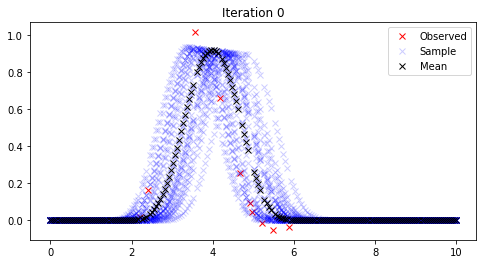

Iteration 100
a= 1.5985835790634155 ,  b= 0.36373966932296753


<Figure size 432x288 with 0 Axes>

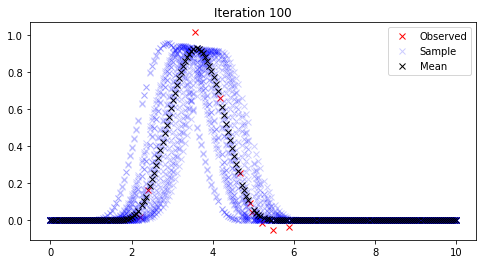

Iteration 200
a= 1.6000254154205322 ,  b= 0.2506345212459564


<Figure size 432x288 with 0 Axes>

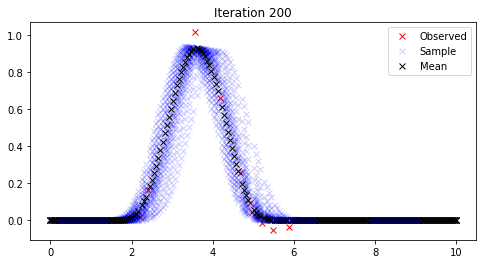

Iteration 300
a= 1.6332086324691772 ,  b= 0.19589391350746155


<Figure size 432x288 with 0 Axes>

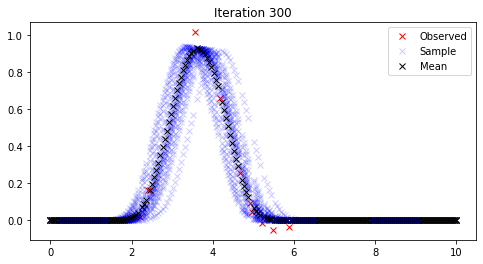

Iteration 400
a= 1.6072862148284912 ,  b= 0.16742563247680664


<Figure size 432x288 with 0 Axes>

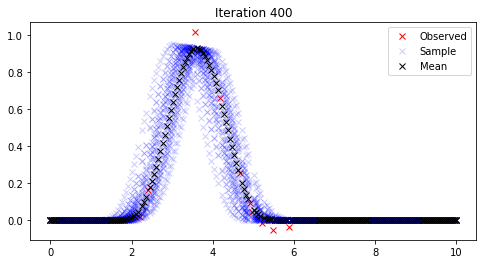

Iteration 500
a= 1.6155956983566284 ,  b= 0.1515909731388092


<Figure size 432x288 with 0 Axes>

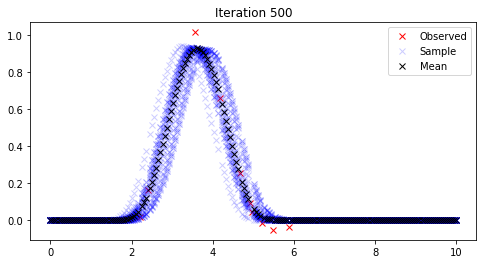

Iteration 600
a= 1.6048319339752197 ,  b= 0.13703082501888275


<Figure size 432x288 with 0 Axes>

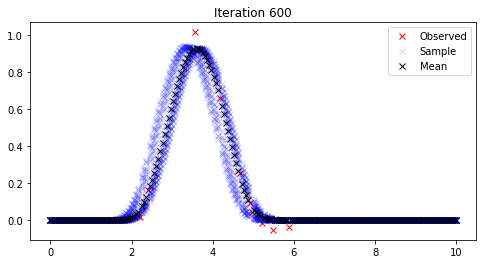

Iteration 700
a= 1.5882822275161743 ,  b= 0.1238378956913948


<Figure size 432x288 with 0 Axes>

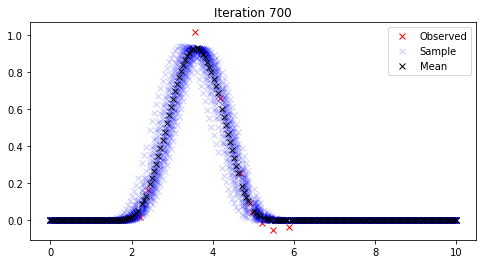

Iteration 800
a= 1.5798572301864624 ,  b= 0.10925126075744629


<Figure size 432x288 with 0 Axes>

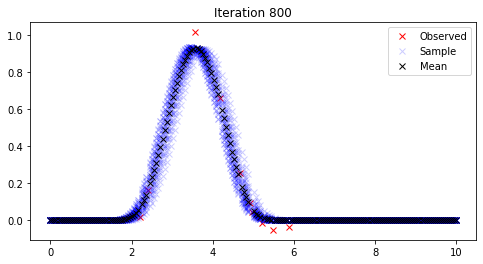

Iteration 900
a= 1.6203322410583496 ,  b= 0.10111977905035019


<Figure size 432x288 with 0 Axes>

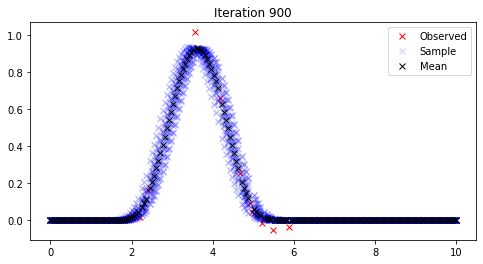

Iteration 1000
a= 1.603014349937439 ,  b= 0.09346772730350494


<Figure size 432x288 with 0 Axes>

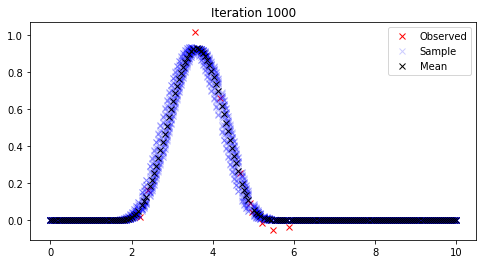

Iteration 1100
a= 1.5887863636016846 ,  b= 0.08780793845653534


<Figure size 432x288 with 0 Axes>

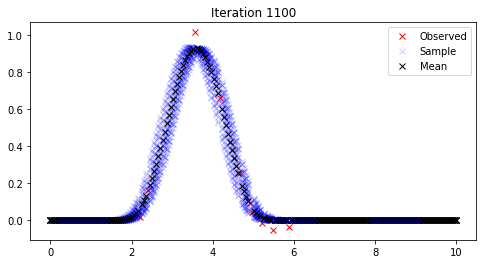

Iteration 1200
a= 1.5943591594696045 ,  b= 0.08381561189889908


<Figure size 432x288 with 0 Axes>

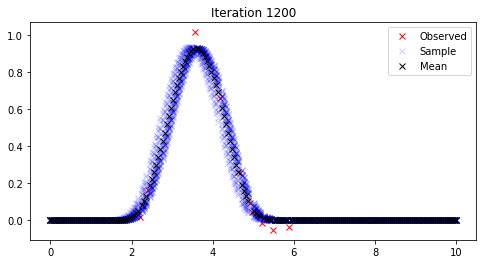

Iteration 1300
a= 1.5984199047088623 ,  b= 0.07784795761108398


<Figure size 432x288 with 0 Axes>

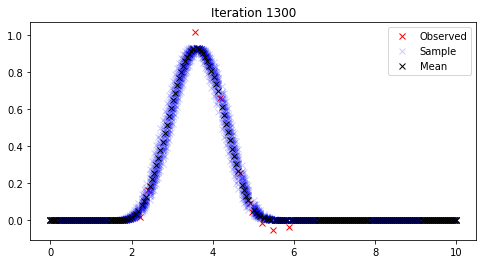

Iteration 1400
a= 1.594932198524475 ,  b= 0.07397639751434326


<Figure size 432x288 with 0 Axes>

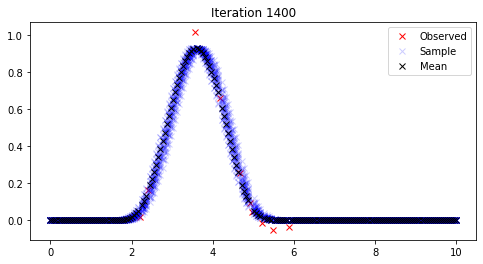

Iteration 1500
a= 1.591789960861206 ,  b= 0.0711517408490181


<Figure size 432x288 with 0 Axes>

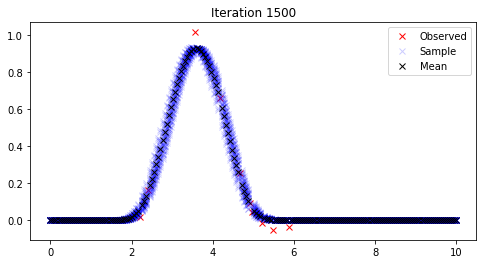

Iteration 1600
a= 1.6225095987319946 ,  b= 0.06773147732019424


<Figure size 432x288 with 0 Axes>

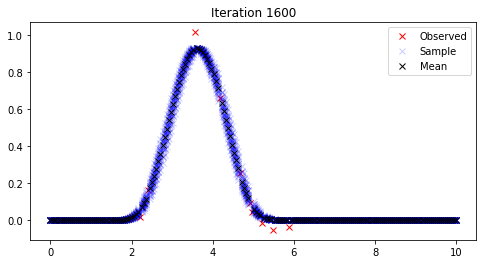

Iteration 1700
a= 1.6124249696731567 ,  b= 0.06509885936975479


<Figure size 432x288 with 0 Axes>

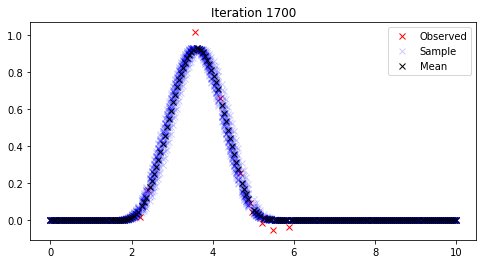

Iteration 1800
a= 1.612510085105896 ,  b= 0.06294350326061249


<Figure size 432x288 with 0 Axes>

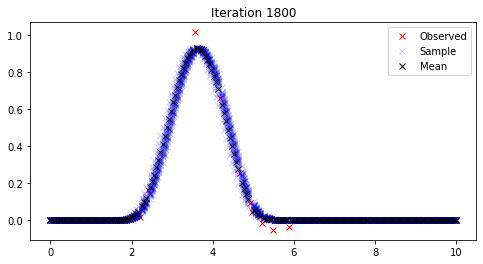

Iteration 1900
a= 1.6032415628433228 ,  b= 0.06097488850355148


<Figure size 432x288 with 0 Axes>

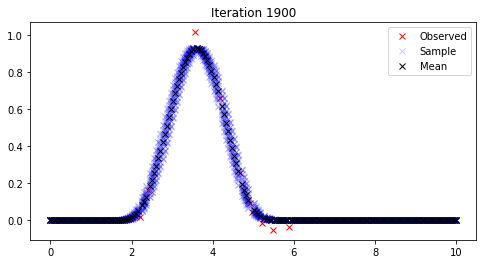

Iteration 2000
a= 1.6111812591552734 ,  b= 0.057960785925388336


<Figure size 432x288 with 0 Axes>

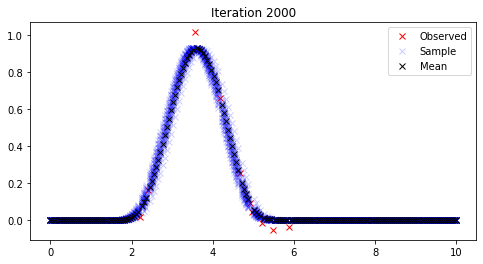

Iteration 2100
a= 1.605041742324829 ,  b= 0.056866779923439026


<Figure size 432x288 with 0 Axes>

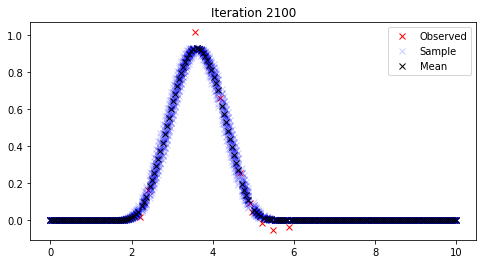

Iteration 2200
a= 1.6243157386779785 ,  b= 0.05439549311995506


<Figure size 432x288 with 0 Axes>

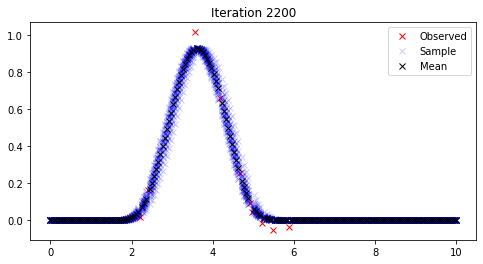

Iteration 2300
a= 1.5932062864303589 ,  b= 0.052491527050733566


<Figure size 432x288 with 0 Axes>

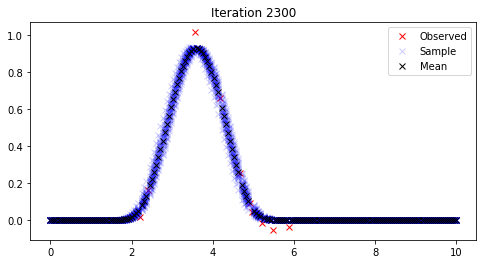

Iteration 2400
a= 1.6114726066589355 ,  b= 0.05099894851446152


<Figure size 432x288 with 0 Axes>

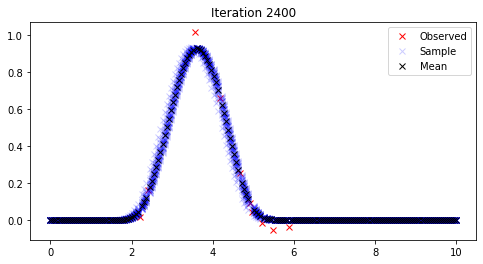

Iteration 2500
a= 1.6032012701034546 ,  b= 0.050265535712242126


<Figure size 432x288 with 0 Axes>

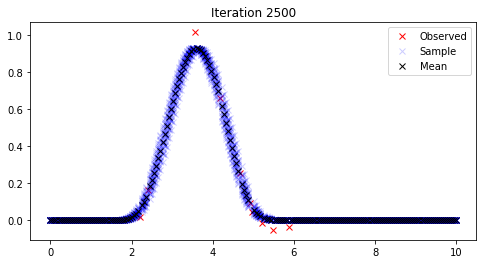

Iteration 2600
a= 1.6086825132369995 ,  b= 0.04943958669900894


<Figure size 432x288 with 0 Axes>

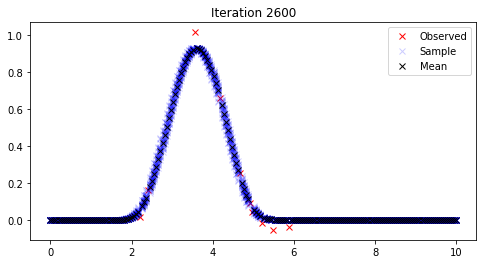

Iteration 2700
a= 1.6323896646499634 ,  b= 0.04793088883161545


<Figure size 432x288 with 0 Axes>

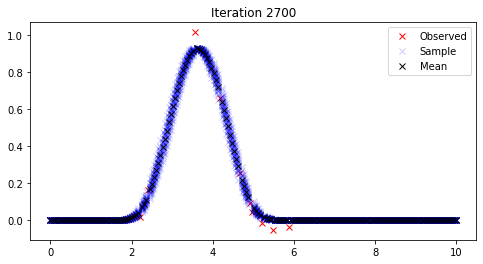

Iteration 2800
a= 1.6118015050888062 ,  b= 0.04688558727502823


<Figure size 432x288 with 0 Axes>

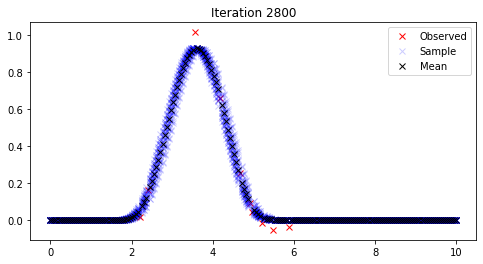

Iteration 2900
a= 1.620020866394043 ,  b= 0.04559176415205002


<Figure size 432x288 with 0 Axes>

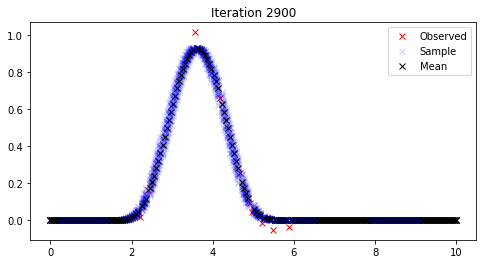

Iteration 3000
a= 1.6136261224746704 ,  b= 0.04417187348008156


<Figure size 432x288 with 0 Axes>

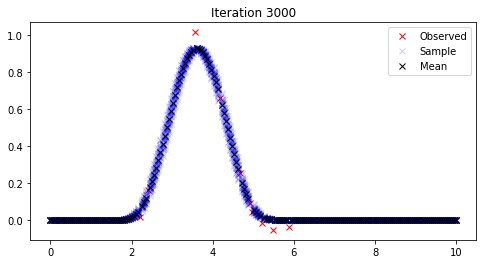

Iteration 3100
a= 1.6055221557617188 ,  b= 0.04334232583642006


<Figure size 432x288 with 0 Axes>

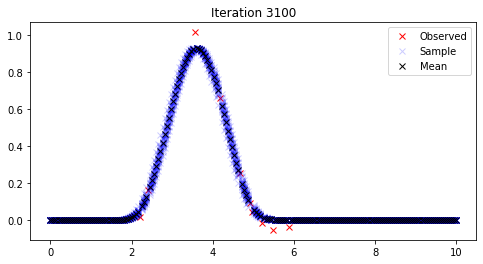

Iteration 3200
a= 1.6158478260040283 ,  b= 0.0426458939909935


<Figure size 432x288 with 0 Axes>

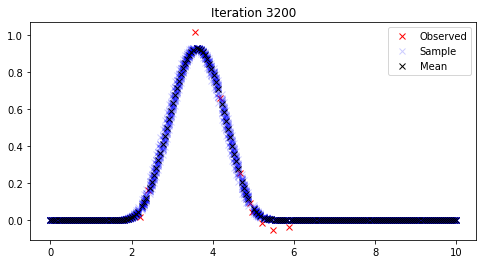

Iteration 3300
a= 1.607750654220581 ,  b= 0.04201020300388336


<Figure size 432x288 with 0 Axes>

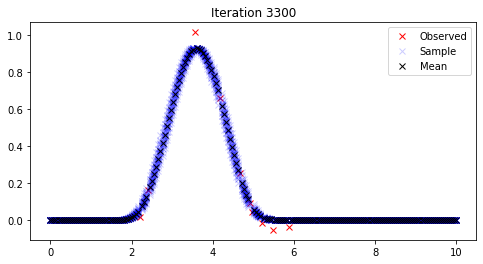

Iteration 3400
a= 1.6199790239334106 ,  b= 0.0410427525639534


<Figure size 432x288 with 0 Axes>

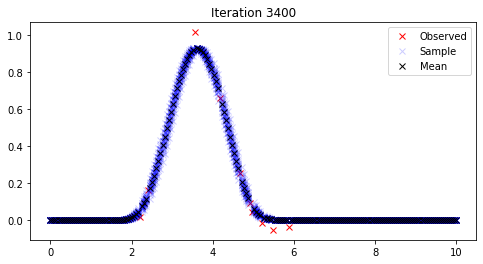

Iteration 3500
a= 1.6192200183868408 ,  b= 0.04030732065439224


<Figure size 432x288 with 0 Axes>

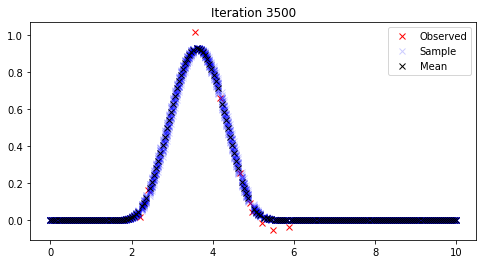

Iteration 3600
a= 1.6009267568588257 ,  b= 0.039041049778461456


<Figure size 432x288 with 0 Axes>

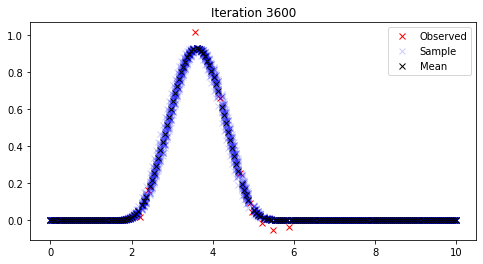

Iteration 3700
a= 1.6247042417526245 ,  b= 0.038240011781454086


<Figure size 432x288 with 0 Axes>

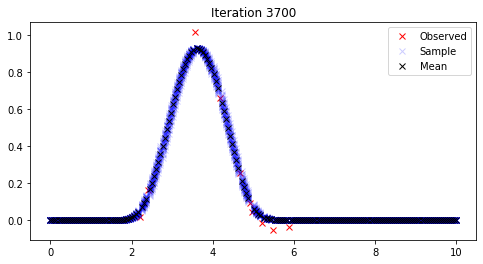

Iteration 3800
a= 1.5996521711349487 ,  b= 0.037927329540252686


<Figure size 432x288 with 0 Axes>

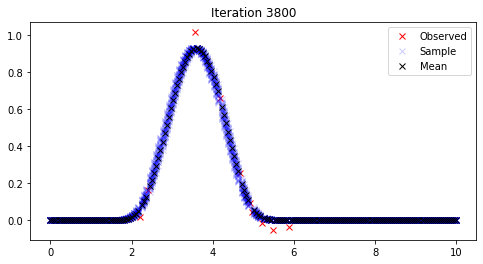

Iteration 3900
a= 1.6020625829696655 ,  b= 0.037695325911045074


<Figure size 432x288 with 0 Axes>

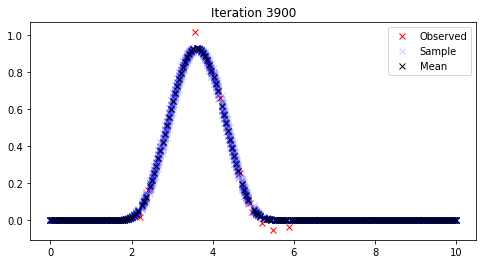

Iteration 4000
a= 1.610655426979065 ,  b= 0.037398964166641235


<Figure size 432x288 with 0 Axes>

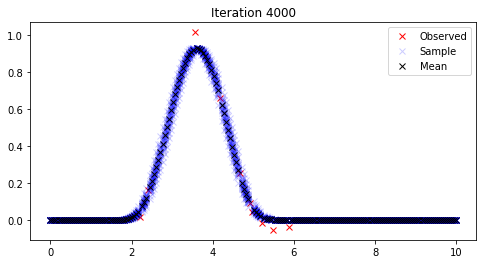

Iteration 4100
a= 1.631190299987793 ,  b= 0.037230558693408966


<Figure size 432x288 with 0 Axes>

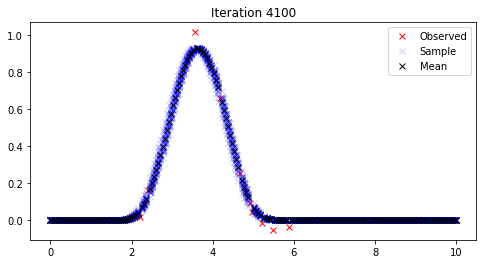

Iteration 4200
a= 1.6055890321731567 ,  b= 0.03686673939228058


<Figure size 432x288 with 0 Axes>

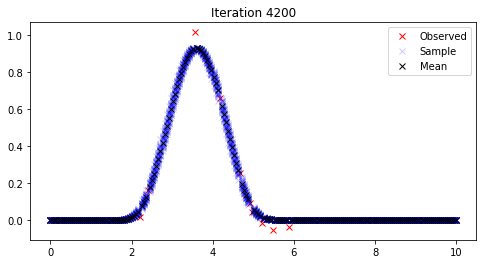

Iteration 4300
a= 1.6108449697494507 ,  b= 0.03628399968147278


<Figure size 432x288 with 0 Axes>

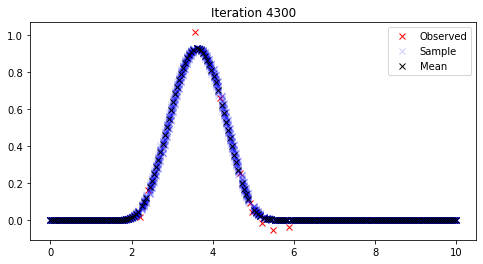

Iteration 4400
a= 1.6018879413604736 ,  b= 0.03611891344189644


<Figure size 432x288 with 0 Axes>

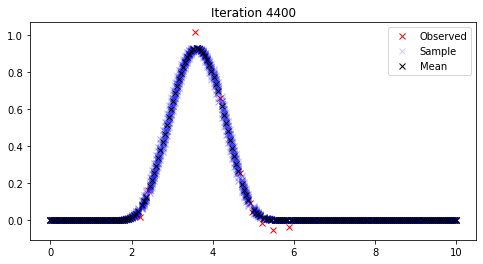

Iteration 4500
a= 1.5990839004516602 ,  b= 0.0361621268093586


<Figure size 432x288 with 0 Axes>

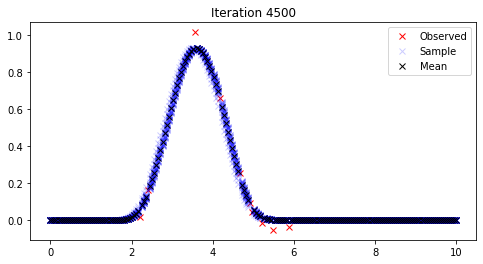

Iteration 4600
a= 1.5938527584075928 ,  b= 0.03538639843463898


<Figure size 432x288 with 0 Axes>

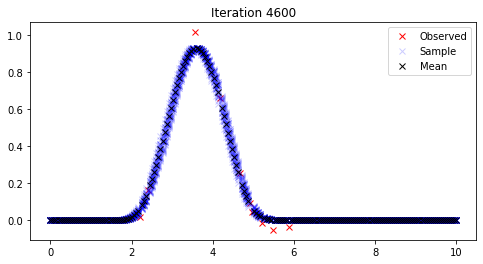

Iteration 4700
a= 1.6119978427886963 ,  b= 0.03406792879104614


<Figure size 432x288 with 0 Axes>

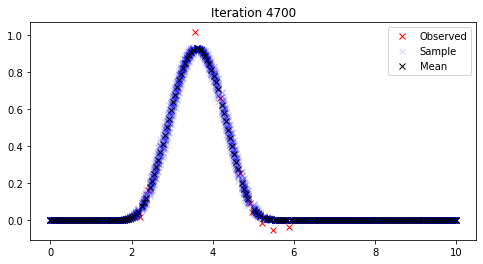

Iteration 4800
a= 1.6021711826324463 ,  b= 0.03330143168568611


<Figure size 432x288 with 0 Axes>

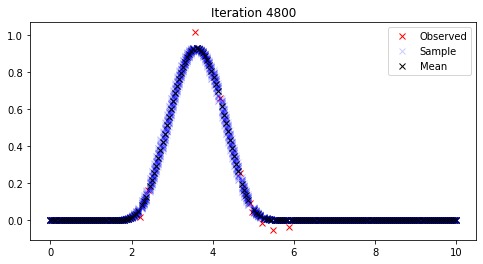

Iteration 4900
a= 1.6080857515335083 ,  b= 0.033441971987485886


<Figure size 432x288 with 0 Axes>

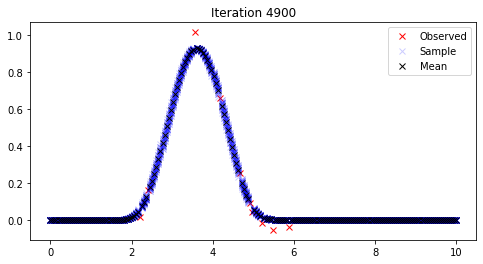

Iteration 5000
a= 1.5911003351211548 ,  b= 0.033765606582164764


<Figure size 432x288 with 0 Axes>

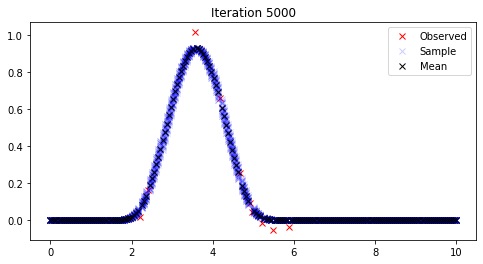

Iteration 5100
a= 1.613446831703186 ,  b= 0.033483922481536865


<Figure size 432x288 with 0 Axes>

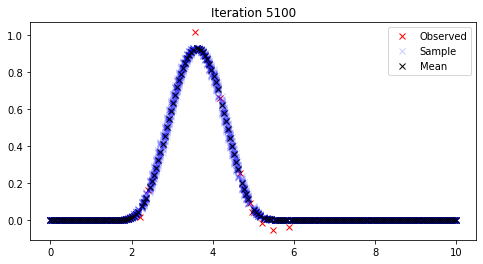

Iteration 5200
a= 1.6015857458114624 ,  b= 0.03379940986633301


<Figure size 432x288 with 0 Axes>

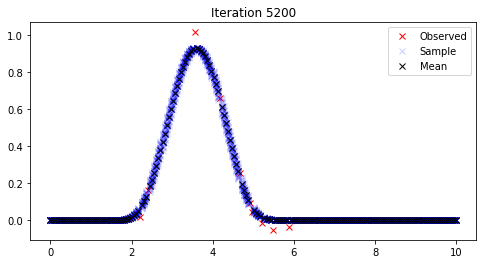

Iteration 5300
a= 1.6147772073745728 ,  b= 0.03340728208422661


<Figure size 432x288 with 0 Axes>

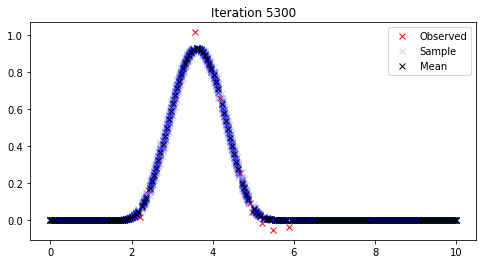

Iteration 5400
a= 1.6302458047866821 ,  b= 0.03340963274240494


<Figure size 432x288 with 0 Axes>

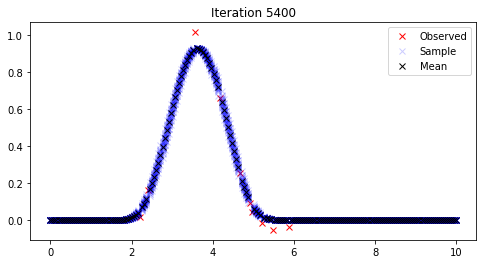

Iteration 5500
a= 1.626420259475708 ,  b= 0.03365972638130188


<Figure size 432x288 with 0 Axes>

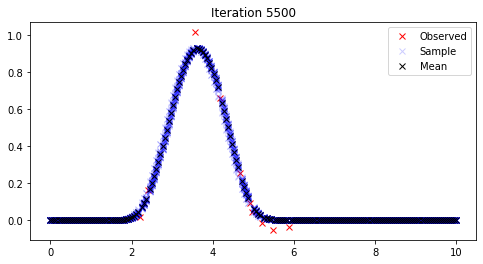

Iteration 5600
a= 1.6050831079483032 ,  b= 0.0340745747089386


<Figure size 432x288 with 0 Axes>

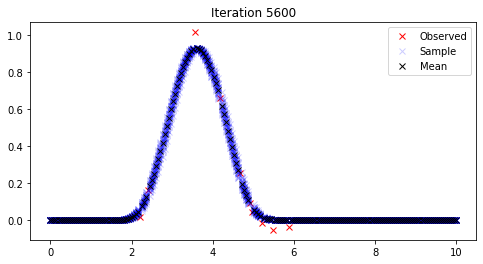

Iteration 5700
a= 1.6199151277542114 ,  b= 0.033719129860401154


<Figure size 432x288 with 0 Axes>

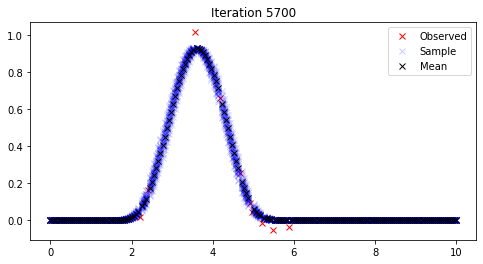

Iteration 5800
a= 1.6095187664031982 ,  b= 0.03405695781111717


<Figure size 432x288 with 0 Axes>

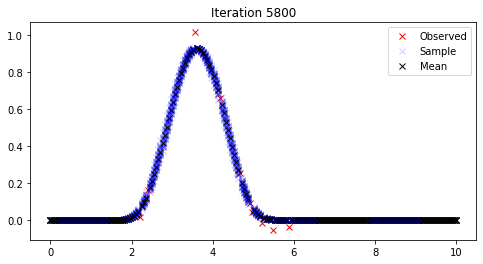

Iteration 5900
a= 1.614808440208435 ,  b= 0.03475428372621536


<Figure size 432x288 with 0 Axes>

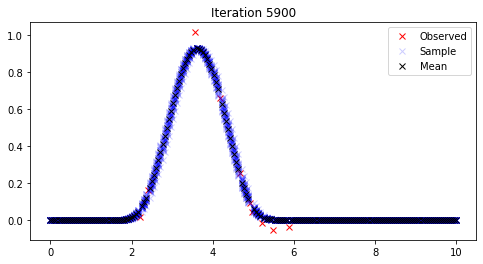

Iteration 6000
a= 1.606547474861145 ,  b= 0.034061383455991745


<Figure size 432x288 with 0 Axes>

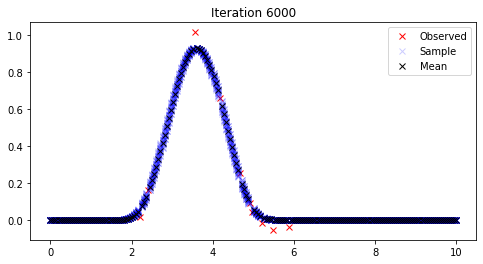

Iteration 6100
a= 1.5984634160995483 ,  b= 0.03400236368179321


<Figure size 432x288 with 0 Axes>

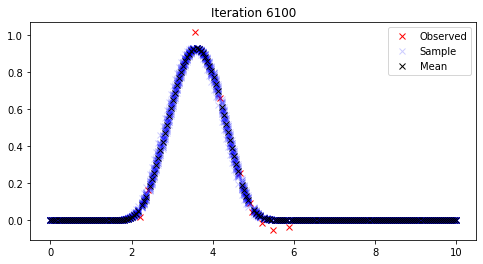

Iteration 6200
a= 1.5824191570281982 ,  b= 0.03483729064464569


<Figure size 432x288 with 0 Axes>

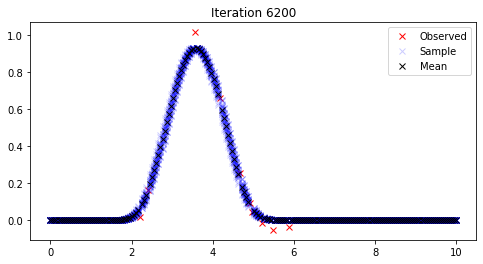

Iteration 6300
a= 1.620951533317566 ,  b= 0.03496715426445007


<Figure size 432x288 with 0 Axes>

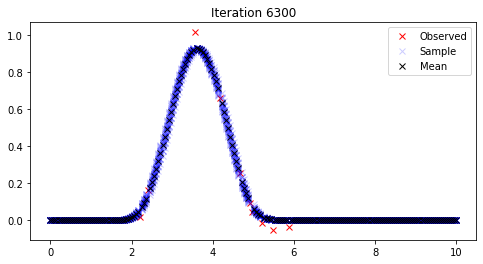

Iteration 6400
a= 1.6025418043136597 ,  b= 0.0355958417057991


<Figure size 432x288 with 0 Axes>

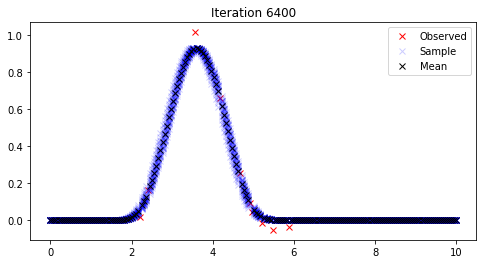

Iteration 6500
a= 1.630436897277832 ,  b= 0.034057632088661194


<Figure size 432x288 with 0 Axes>

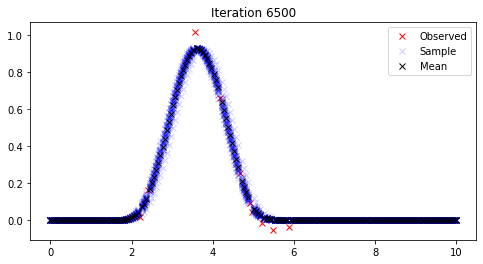

Iteration 6600
a= 1.6040260791778564 ,  b= 0.03349006175994873


<Figure size 432x288 with 0 Axes>

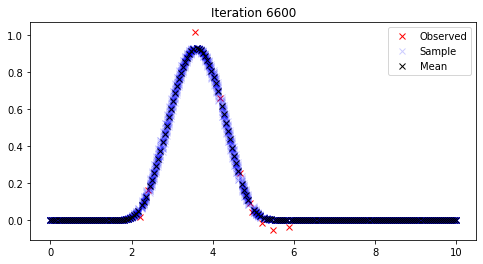

Iteration 6700
a= 1.5986247062683105 ,  b= 0.03364476189017296


<Figure size 432x288 with 0 Axes>

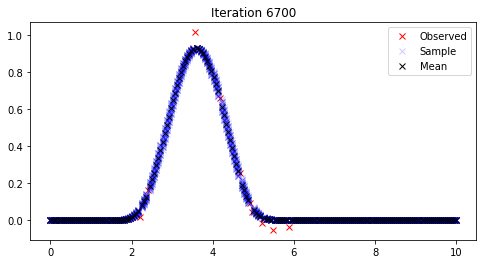

Iteration 6800
a= 1.6198660135269165 ,  b= 0.03398585319519043


<Figure size 432x288 with 0 Axes>

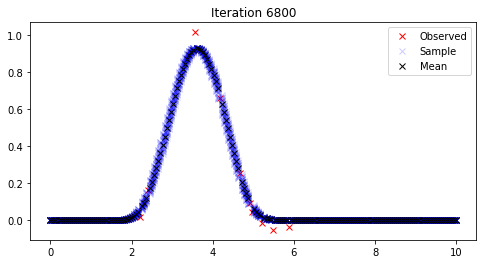

Iteration 6900
a= 1.6014212369918823 ,  b= 0.0330161489546299


<Figure size 432x288 with 0 Axes>

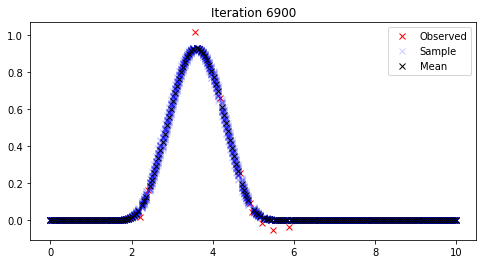

Iteration 7000
a= 1.6232463121414185 ,  b= 0.03429097682237625


<Figure size 432x288 with 0 Axes>

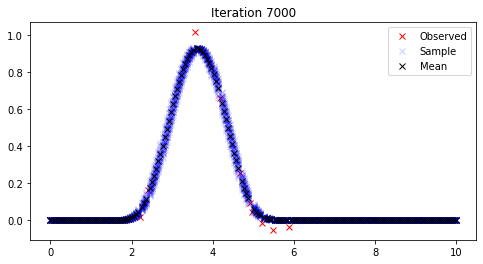

Iteration 7100
a= 1.5855937004089355 ,  b= 0.03451469913125038


<Figure size 432x288 with 0 Axes>

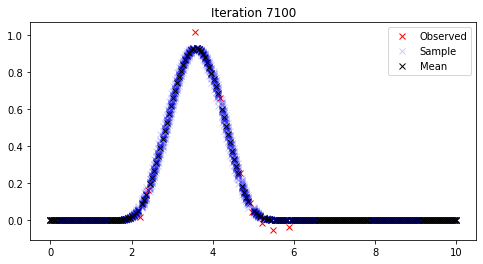

Iteration 7200
a= 1.6047561168670654 ,  b= 0.035261474549770355


<Figure size 432x288 with 0 Axes>

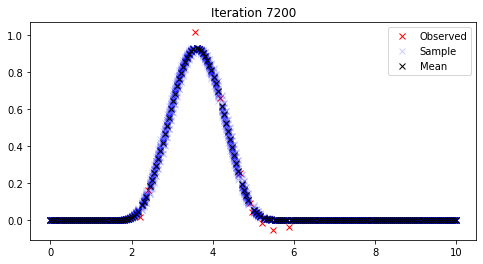

Iteration 7300
a= 1.606524109840393 ,  b= 0.03445757180452347


<Figure size 432x288 with 0 Axes>

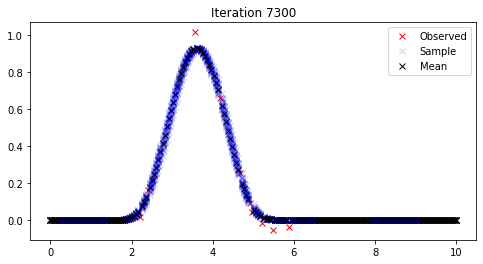

Iteration 7400
a= 1.6247899532318115 ,  b= 0.03456568345427513


<Figure size 432x288 with 0 Axes>

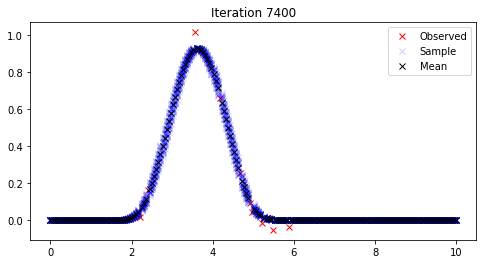

Iteration 7500
a= 1.5851596593856812 ,  b= 0.03436284139752388


<Figure size 432x288 with 0 Axes>

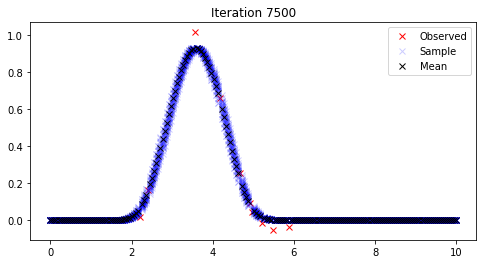

Iteration 7600
a= 1.6012319326400757 ,  b= 0.03506648540496826


<Figure size 432x288 with 0 Axes>

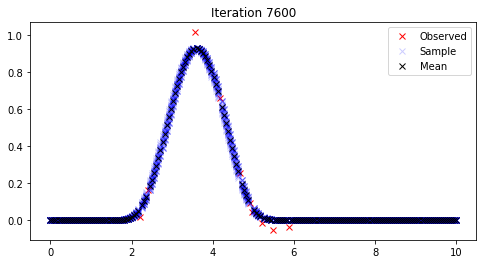

Iteration 7700
a= 1.59286367893219 ,  b= 0.0352952778339386


<Figure size 432x288 with 0 Axes>

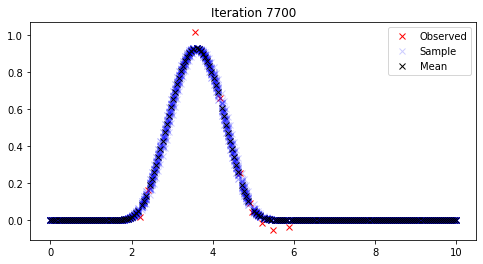

Iteration 7800
a= 1.6045892238616943 ,  b= 0.0339047834277153


<Figure size 432x288 with 0 Axes>

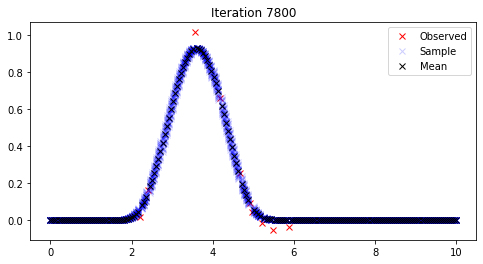

Iteration 7900
a= 1.6137243509292603 ,  b= 0.03329387307167053


<Figure size 432x288 with 0 Axes>

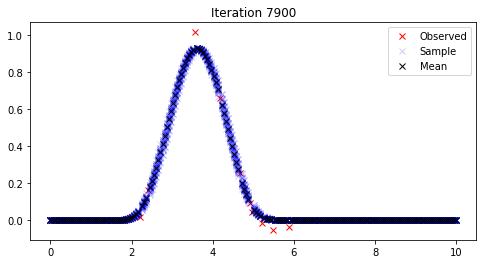

Iteration 8000
a= 1.5981289148330688 ,  b= 0.03421087563037872


<Figure size 432x288 with 0 Axes>

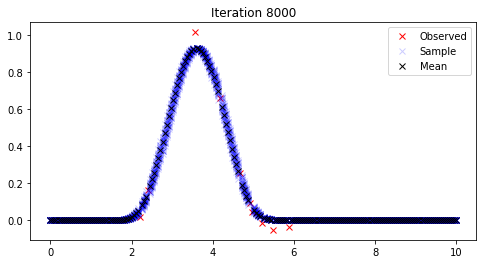

Iteration 8100
a= 1.6163872480392456 ,  b= 0.03422046825289726


<Figure size 432x288 with 0 Axes>

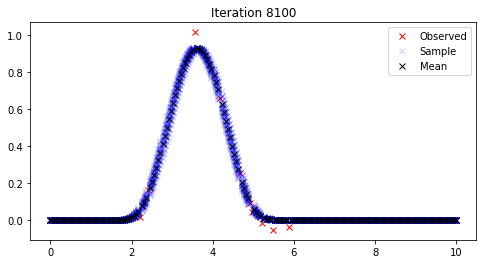

Iteration 8200
a= 1.6062880754470825 ,  b= 0.034696128219366074


<Figure size 432x288 with 0 Axes>

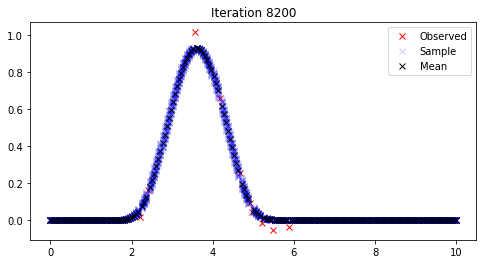

Iteration 8300
a= 1.6191771030426025 ,  b= 0.03394089639186859


<Figure size 432x288 with 0 Axes>

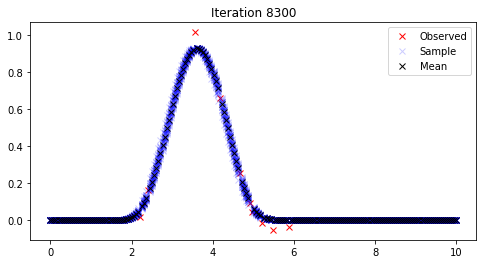

Iteration 8400
a= 1.5987523794174194 ,  b= 0.03333628922700882


<Figure size 432x288 with 0 Axes>

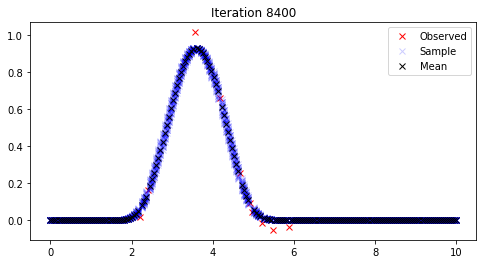

Iteration 8500
a= 1.5914356708526611 ,  b= 0.03541550040245056


<Figure size 432x288 with 0 Axes>

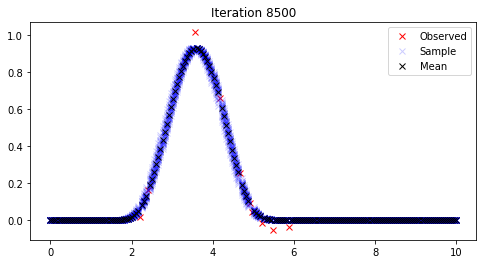

Iteration 8600
a= 1.6194263696670532 ,  b= 0.0339597724378109


<Figure size 432x288 with 0 Axes>

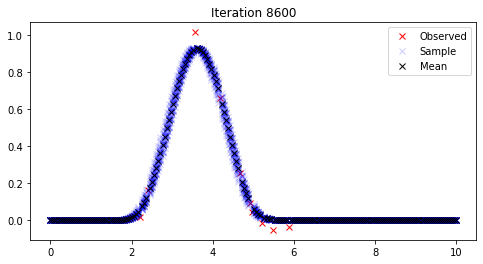

Iteration 8700
a= 1.594769835472107 ,  b= 0.030887383967638016


<Figure size 432x288 with 0 Axes>

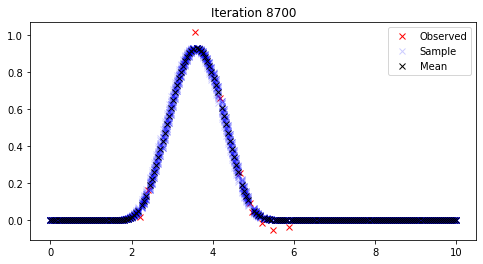

Iteration 8800
a= 1.607487440109253 ,  b= 0.03211383894085884


<Figure size 432x288 with 0 Axes>

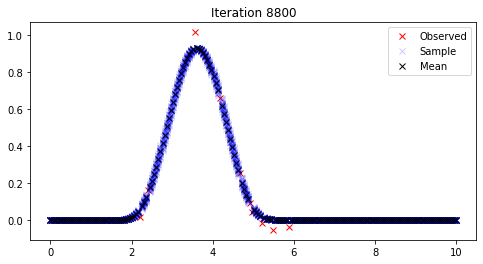

Iteration 8900
a= 1.5971311330795288 ,  b= 0.030482282862067223


<Figure size 432x288 with 0 Axes>

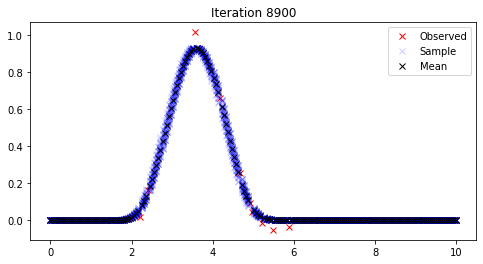

Iteration 9000
a= 1.6120659112930298 ,  b= 0.031044935807585716


<Figure size 432x288 with 0 Axes>

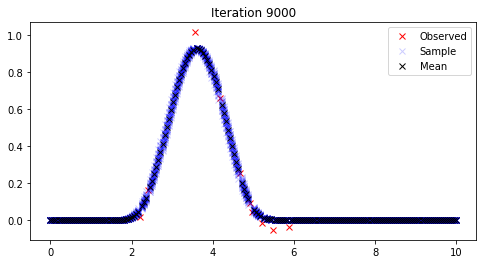

Iteration 9100
a= 1.5943471193313599 ,  b= 0.034068264067173004


<Figure size 432x288 with 0 Axes>

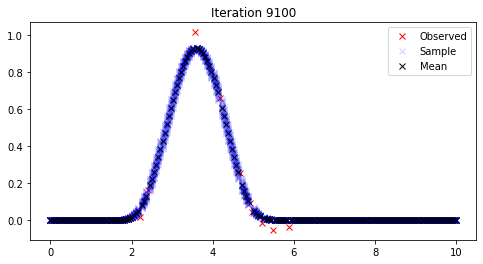

Iteration 9200
a= 1.6174451112747192 ,  b= 0.03332916647195816


<Figure size 432x288 with 0 Axes>

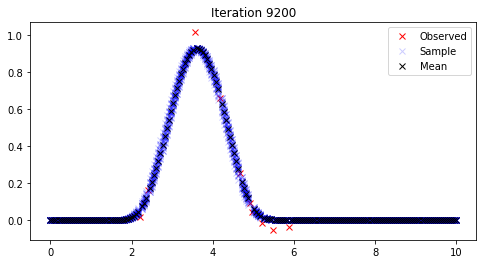

Iteration 9300
a= 1.6081528663635254 ,  b= 0.03388843685388565


<Figure size 432x288 with 0 Axes>

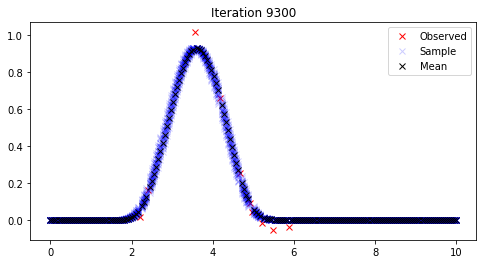

Iteration 9400
a= 1.5946714878082275 ,  b= 0.034679532051086426


<Figure size 432x288 with 0 Axes>

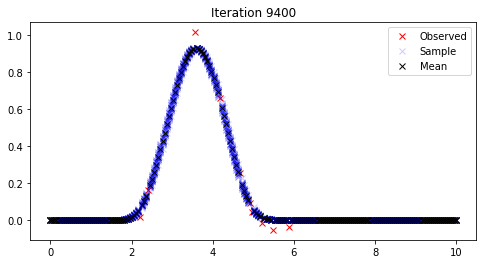

Iteration 9500
a= 1.582398533821106 ,  b= 0.03500572592020035


<Figure size 432x288 with 0 Axes>

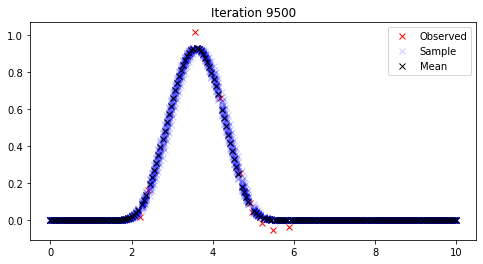

Iteration 9600
a= 1.6038012504577637 ,  b= 0.033331144601106644


<Figure size 432x288 with 0 Axes>

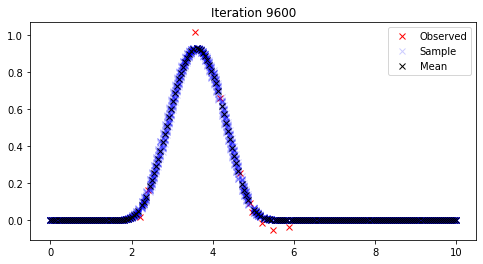

Iteration 9700
a= 1.6299407482147217 ,  b= 0.030107636004686356


<Figure size 432x288 with 0 Axes>

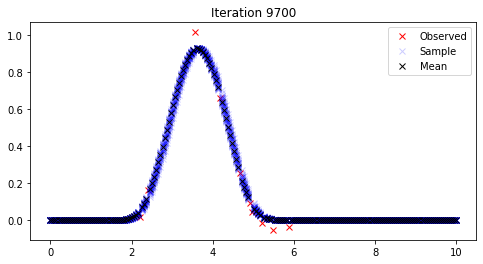

Iteration 9800
a= 1.6150448322296143 ,  b= 0.03287344425916672


<Figure size 432x288 with 0 Axes>

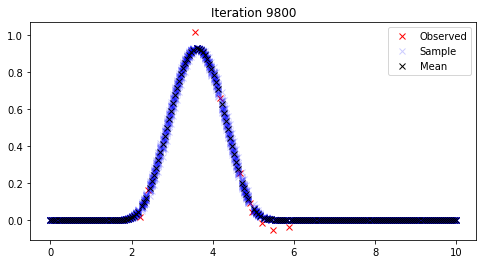

Iteration 9900
a= 1.5962903499603271 ,  b= 0.03316081315279007


<Figure size 432x288 with 0 Axes>

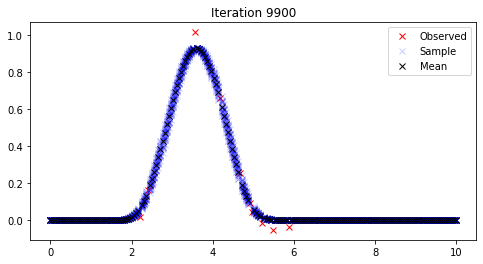

CPU times: user 11min 4s, sys: 6.7 s, total: 11min 11s
Wall time: 11min 17s


In [13]:
%%time
pyro.clear_param_store()
# Set up SVI
adam_params = {"lr": 0.01, "betas": (0.90, 0.999)}
svi = pyro.infer.SVI(model=conditioned_model, 
                     guide=parameterised_guide,
                     optim=pyro.optim.Adam(adam_params),
                     loss=pyro.infer.Trace_ELBO()
                     )
num_steps = 10000

# Save all parameters and losses
param_names = ['a','b']
params, losses = np.zeros((num_steps,len(param_names))), np.zeros(num_steps)

# Run SVI
for t in range(num_steps):
    losses[t] = svi.step(guess, observed_inds, nx, L, nt, dt, obs_err)
    params[t,:] = [pyro.param(param_names[i]).item() for i in range(len(param_names))]
    
    if (t%100==0.):
        plot_at_iteration(t, x, guess, observed_h, observed_inds, nx, L, nt, dt, obs_err) 
        

a =  1.614097237586975
b =  0.032828833907842636


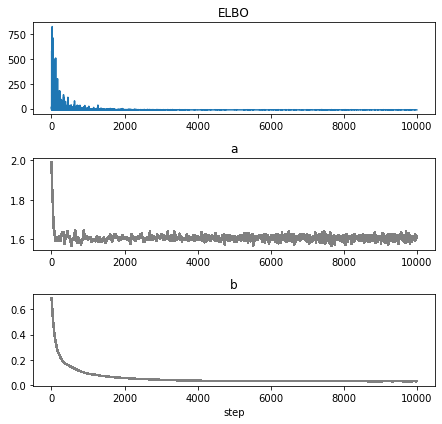

In [14]:
a = pyro.param("a").item()
b = pyro.param("b").item()
print("a = ", a)
print("b = ", b)

fig = plt.figure(figsize=(12,6))

ax = plt.subplot2grid((3, 2), (0, 0));
ax.plot(losses);
plt.title("ELBO");

ax1 = plt.subplot2grid((3, 2), (1, 0));
for i in range(nx):
    ax1.plot(params[:,0],'grey')
plt.title('a');

ax2 = plt.subplot2grid((3, 2), (2, 0));
for i in range(nx):
    ax2.plot(params[:,1],'grey')
plt.title('b');
plt.xlabel("step");


plt.tight_layout();

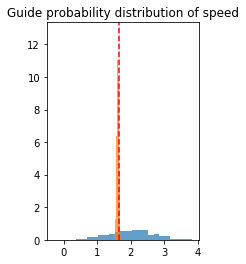

In [15]:
speed_guide_final = [parameterised_guide(guess, observed_inds, nx, L, nt, dt, obs_err).item() 
                     for i in range(1000)]
fig = plt.figure()
ax1 = plt.subplot2grid((1, 2), (0, 1));
ax1.hist(speed_guide, 25, density=True, alpha=0.7, label="Guide before optimisation");
ax1.hist(speed_guide_final, 25, density=True, alpha=0.7, label="Guide after optimisation");
ax1.axvline(np.mean(true_speed), c="red", ls="--",label="True observed speed");
plt.title("Guide probability distribution of speed");

Once it looks like the distribution for the speed has converged, we can use this to do useful things, like sample from the distribution and make predictions about the position of the wave at different time points, in just two lines of code, e.g.

In [16]:
speed = dist.Normal(a, b).sample()
h_predicted = advect(speed, h0, nx, nt, dt, dx) 

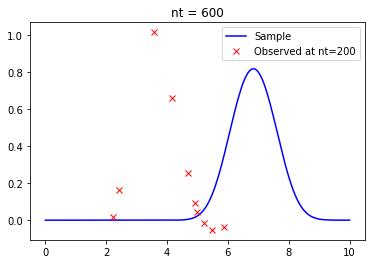

In [17]:
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
fig, ax = plt.subplots()
ln, = plt.plot([], [])

def init():
    ax.set_xlim(0, 10.)
    ax.set_ylim(0., 1)
    return ln,

def update(frame):
    h = advect(a, h0, nx, frame, dt, dx) 
    ln.set_data(x.numpy(), h.numpy())
    plt.clf()
    plt.title('nt = {}'.format(frame))
    plt.plot(x.numpy(), h.numpy(), 'b-', label='Sample')
    plt.plot(x.numpy()[observed_inds],
             observed_h.numpy(),'rx',label="Observed at nt=200");
    plt.legend(loc="upper right");
    return ln,

ani = FuncAnimation(fig, update, frames=range(0,700,100), interval=1000,
                    init_func=init, blit=True);

HTML(ani.to_html5_video())
ani.save('time_plot.gif',  writer='imagemagick', fps=3)



## Additional Plots
Code below creates the gif in the blog post. 

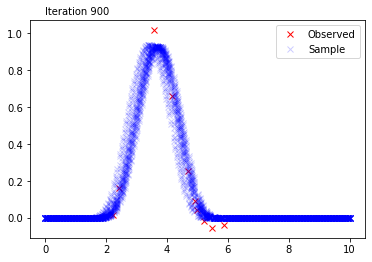

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
not_observed_inds = [i for i in range(nx) 
                         if i not in observed_inds]
fig, ax = plt.subplots()
h = advect(speed, h0, nx, nt, dt, dx) 
ln, = plt.plot(np.zeros(0), np.ones(0), 'bx')
ln_o, = plt.plot(x.numpy()[observed_inds],
             observed_h.numpy(),'rx',label="Observed");
def init():
    ax.set_xlim(0, 10.)
    ax.set_ylim(0., 1)
    return ln,

def update(frame):   
    plt.clf()
    plt.plot(x.numpy()[observed_inds],
             observed_h.numpy(),'rx',label="Observed");
    a, b = params[frame,]
    speed = dist.Normal(a, b).sample()
    h = advect(speed, h0, nx, nt, dt, dx)
    plt.plot(x.numpy()[not_observed_inds],
             h.detach().numpy()[not_observed_inds],'bx',alpha=0.2,label="Sample");
    plt.text(0.,1.1,"Iteration {}".format(str(frame)))
    for i in range(20):
        speed = dist.Normal(a, b).sample()

        h = advect(speed, h0, nx, nt, dt, dx)
        plt.plot(x.numpy()[not_observed_inds],
             h.detach().numpy()[not_observed_inds],'bx',alpha=0.2); 
    plt.legend();

ani = FuncAnimation(fig, update, frames=range(0,1000 ,100), interval=500, 
                    init_func=init, blit=False);
HTML(ani.to_html5_video())

#ani.save('iterations.gif',  writer='imagemagick', fps=3)


We can sample from the speed and make future predictions of the position of the wave. We could also use the speed in a higher resolution model to get more accurate values for the height, at a future timestep. This could also be used in different models (eg. diffusion, etc.)

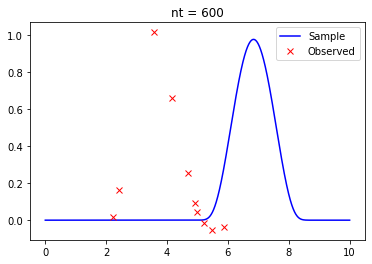

In [19]:
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
fig, ax = plt.subplots()
ln, = plt.plot([], [])
# Initialise and plot
nx_highres = nx*10
dx_highres = L/(nx_highres - 1)
dt_highres = dt/10
x_highres = torch.linspace(0., L, nx_highres)
h0_highres = initial_cond(x_highres, start=0.5, end=3.5)

def init():
    ax.set_xlim(0, 10.)
    ax.set_ylim(0., 1)
    return ln,

def update(frame):
    h_highres = advect(a, h0_highres, nx_highres, frame*10, dt_highres, dx_highres) 
    ln.set_data(x_highres.numpy(), h_highres.numpy())
    plt.clf()
    plt.title('nt = {}'.format(frame))
    plt.plot(x_highres.numpy(), h_highres.numpy(), 'b-', label='Sample')
    plt.plot(x.numpy()[observed_inds],
             observed_h.numpy(),'rx',label="Observed");
    plt.legend();
    return ln,

ani = FuncAnimation(fig, update, frames=range(0,700,100), interval=1000,
                    init_func=init, blit=True);

HTML(ani.to_html5_video())

